# Assignment 1 - Building a Vision Model with Keras

In this assignment, you will build a simple vision model using Keras. The goal is to classify images from the Fashion MNIST dataset, which contains images of clothing items.

You will:
1. Load and inspect the Fashion MNIST dataset.
2. Run a simple baseline model to establish a performance benchmark.
3. Build and evaluate a simple CNN model, choosing appropriate loss and metrics.
4. Design and run controlled experiments on one hyperparameter (e.g., number of filters, kernel size, etc.) and one regularization technique (e.g., dropout, L2 regularization).
5. Analyze the results and visualize the model's performance.

# 1. Loading and Inspecting the Dataset

Fashion MNIST is a dataset of grayscale images of clothing items, with 10 classes. Each image is 28x28 pixels, like the MNIST dataset of handwritten digits. Keras provides a convenient way to load this dataset. 

In this section, you should:

- [ ] Inspect the shapes of the training and test sets to confirm their size and structure.
- [ ] Convert the labels to one-hot encoded format if necessary. (There is a utility function in Keras for this.)
- [ ] Visualize a few images from the dataset to understand what the data looks like.

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Classes in the Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [3]:
# Inspect the shapes of the datasets    
print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)   

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
# Reshape the data to fit the model
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_test = X_test.reshape((X_test.shape[0], 28 * 28)) 



Training data shape: (60000, 28, 28) (60000,)
Test data shape: (10000, 28, 28) (10000,)


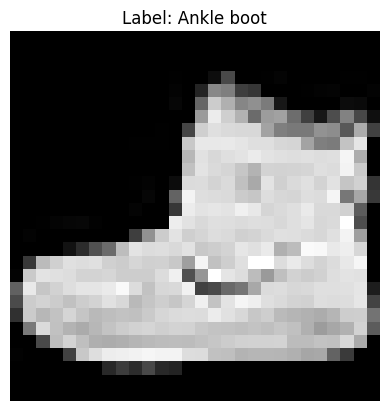

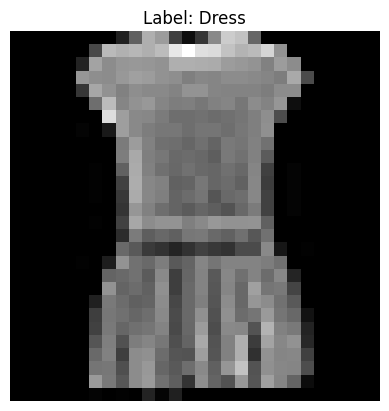

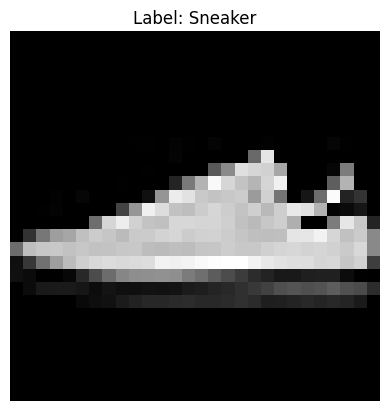

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# Verify the data looks as expected
def plot_sample(X, y, index):
    plt.imshow(X[index].reshape(28, 28), cmap='gray')
    # use the nupmy argmax function to get the index of the maximum value in y as that is a one-hot encoded vector
    label_idx = np.argmax(y[index])
    plt.title(f"Label: {class_names[label_idx]}")
    plt.axis('off')
    plt.show()  

# Plot a sample from the training set
plot_sample(X_train, y_train, index=0)
plot_sample(X_train, y_train, index=3)
plot_sample(X_train, y_train, index=6)



Reflection: Does the data look as expected? How is the quality of the images? Are there any issues with the dataset that you notice?

**Your answer here**

# 2. Baseline Model

In this section, you will create a linear regression model as a baseline. This model will not use any convolutional layers, but it will help you understand the performance of a simple model on this dataset.
You should:
- [ ] Create a simple linear regression model using Keras.
- [ ] Compile the model with an appropriate loss function and optimizer.
- [ ] Train the model on the training set and evaluate it on the test set.

A linear regression model can be created using the `Sequential` API in Keras. Using a single `Dense` layer with no activation function is equivalent to a simple linear regression model. Make sure that the number of units in the output layer matches the number of classes in the dataset.

Note that for this step, we will need to use `Flatten` to convert the 2D images into 1D vectors before passing them to the model. Put a `Flatten()` layer as the first layer in your model so that the 2D image data can be flattened into 1D vectors.

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import initializers
from keras.optimizers import Adam

# Create a simple linear regression model
model = Sequential()
# You can use `model.add(<layer>)` to add layers to the model
model.add(Flatten(input_shape=(28 * 28,)))  # Flatten the input
# add two hidden layers with 128 neurons each and ReLU activation
model.add(Dense(128, activation='relu'))  # Hidden layer with 128 neurons and
model.add(Dense(128, activation='relu'))  # Hidden layer with 128 neurons and
# add an output layer with 10 neurons (one for each class) and softmax activation
model.add(Dense(10, activation='softmax'))  # Output layer with 10 neurons


# Compile the model using `model.compile()`
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Train the model with `model.fit()`
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# Evaluate the model with `model.evaluate()`
loss, accuracy = model.evaluate(X_test, y_test)

print(f'update Loss when use ADAM : {loss:.2f}')
print(f'update Accuracy when use ADAM : {accuracy*100:.2f}%')

Epoch 1/15


/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7552 - loss: 0.6970 - val_accuracy: 0.8321 - val_loss: 0.4840
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8348 - loss: 0.4635 - val_accuracy: 0.8431 - val_loss: 0.4340
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8467 - loss: 0.4279 - val_accuracy: 0.8582 - val_loss: 0.4201
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8562 - loss: 0.4038 - val_accuracy: 0.8291 - val_loss: 0.4637
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8559 - loss: 0.3973 - val_accuracy: 0.8463 - val_loss: 0.4590
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8605 - loss: 0.3861 - val_accuracy: 0.8562 - val_loss: 0.4283
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8645 - loss: 0.3848 - val_accuracy: 0.8419 - val_loss: 0.5039
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8645 - loss: 0.3811 - val_accurac

Reflection: What is the performance of the baseline model? How does it compare to what you expected? Why do you think the performance is at this level?

**Your answer here**

# 3. Building and Evaluating a Simple CNN Model

In this section, you will build a simple Convolutional Neural Network (CNN) model using Keras. A convolutional neural network is a type of deep learning model that is particularly effective for image classification tasks. Unlike the basic neural networks we have built in the labs, CNNs can accept images as input without needing to flatten them into vectors.

You should:
- [ ] Build a simple CNN model with at least one convolutional layer (to learn spatial hierarchies in images) and one fully connected layer (to make predictions).
- [ ] Compile the model with an appropriate loss function and metrics for a multi-class classification problem.
- [ ] Train the model on the training set and evaluate it on the test set.

Convolutional layers are designed to accept inputs with three dimensions: height, width and channels (e.g., RGB for color images). For grayscale images like those in Fashion MNIST, the input shape will be (28, 28, 1).

When you progress from the convolutional layers to the fully connected layers, you will need to flatten the output of the convolutional layers. This can be done using the `Flatten` layer in Keras, which doesn't require any parameters.

In [5]:
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Create a simple CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# Add a second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())  # Flatten the output of the convolutional layers

model.add(Dense(10, activation='softmax'))  # Output layer with 10 neurons  

# Compile the model using `model.compile()`
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'update Loss when use CNN : {loss:.2f}')
print(f'update Accuracy when use CNN : {accuracy*100:.2f}%')


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8147 - loss: 0.5182 - val_accuracy: 0.8898 - val_loss: 0.3024
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9023 - loss: 0.2735 - val_accuracy: 0.9046 - val_loss: 0.2633
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9272 - loss: 0.2018 - val_accuracy: 0.9148 - val_loss: 0.2496
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9433 - loss: 0.1585 - val_accuracy: 0.9104 - val_loss: 0.2676
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9573 - loss: 0.1197 - val_accuracy: 0.9099 - val_loss: 0.2737
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9694 - loss: 0.0892 - val_accuracy: 0.9061 - val_loss: 0.3090
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9753 - loss: 0.0691 - val_accuracy: 0.9065 - val_loss: 0.3191
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.9812 -

Reflection: Did the CNN model perform better than the baseline model? If so, by how much? What do you think contributed to this improvement?

**Your answer here**

# 3. Designing and Running Controlled Experiments

In this section, you will design and run controlled experiments to improve the model's performance. You will focus on one hyperparameter and one regularization technique.
You should:
- [ ] Choose one hyperparameter to experiment with (e.g., number of filters, kernel size, number of layers, etc.) and one regularization technique (e.g., dropout, L2 regularization). For your hyperparameter, you should choose at least three different values to test (but there is no upper limit). For your regularization technique, simply test the presence or absence of the technique.
- [ ] Run experiments by modifying the model architecture or hyperparameters, and evaluate the performance of each model on the test set.
- [ ] Record the results of your experiments, including the test accuracy and any other relevant metrics.
- [ ] Visualize the results of your experiments using plots or tables to compare the performance of different models.

The best way to run your experiments is to create a `for` loop that iterates over a range of values for the hyperparameter you are testing. For example, if you are testing different numbers of filters, you can create a loop that runs the model with 32, 64, and 128 filters. Within the loop, you can compile and train the model, then evaluate it on the test set. After each iteration, you can store the results in a list or a dictionary for later analysis.

Note: It's critical that you re-initialize the model (by creating a new instance of the model) before each experiment. If you don't, the model will retain the weights from the previous experiment, which can lead to misleading results.

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten 
from keras.optimizers import Adam
import pandas as pd

columns = ['Filter Size', 'Kernel Size', 'Layers', 'Activation Function',
           'Batch Size', 'Epochs', 'Learning Rate', 'Loss', 'Accuracy']
dataframe = pd.DataFrame(columns=columns)

# A. Test Hyperparameters : Filters, Kernel Sizes, Layers, and Activation Functions
filter_sizes = [32, 64]
no_of_layers = [1, 2]
activation_function = 'relu'  # Using ReLU as the activation function
# B. Test Hyperparameters : Batche Sizes and Epochs (common values)
batch_size = 32
epoch = 10
# C. Test Hyperparameters : Learning Rate and Optimizers
learning_rates = [0.001, 0.01]
# for loop through the hyperparameters
for filter_size in filter_sizes:
        for layer in no_of_layers:
                        for learning_rate in learning_rates:
                                    # Create a simple CNN model
                                    model = Sequential()
                                    model.add(Conv2D(filter_size, kernel_size=(3,3), activation=activation_function, input_shape=(28, 28, 1)))
                                    if layer > 1:
                                        model.add(Conv2D(filter_size * 2, kernel_size=(5,5), activation=activation_function))
                                    model.add(Flatten())
                                    model.add(Dense(10, activation='softmax'))

                                    # Compile the model using `model.compile()`
                                    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
                                    # Train the model using `model.fit()`
                                    history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2)
                                    #plot the training and validation loss
                                    #plt.figure(figsize=(12, 4))
                                    #plt.plot(history.history['loss'], label='Training Loss')
                                    #plt.plot(history.history['val_loss'], label='Validation Loss')
                                    #plt.title('Training and Validation Loss')
                                    #plt.xlabel('Epochs')
                                    #plt.ylabel('Loss')
                                    #plt.legend()
                                    #plt.show()

                                    # Evaluate the model and save the results
                                    loss, accuracy = model.evaluate(X_test, y_test)
                                    # Save the results in the dataframe
                                    model_data = {
                                            'Filter Size': filter_size,
                                            'Kernel Size': (3, 3) if layer == 1 else (5, 5),
                                            'Layers': layer,
                                            'Activation Function': activation_function,
                                            'Batch Size': batch_size,
                                            'Epochs': epoch,
                                            'Learning Rate': learning_rate,
                                            'Loss': loss,
                                            'Accuracy': accuracy
                                         }
                                    dataframe.loc[len(dataframe)] = model_data
                                    print(f'Filter Size: {filter_size}, Kernel Size: (3,3) or (5,5) , Layers: {layer}, Activation: {activation_function}, Batch Size: {batch_size}, Epochs: {epoch}, Learning Rate: {learning_rate}, Optimizer: ADAM => Loss: {loss:.2f}, Accuracy: {accuracy*100:.2f}%')

# The code above is a complete implementation of a CNN model for the Fashion MNIST dataset.
# It includes hyperparameter tuning for filter sizes, kernel sizes, number of layers, activation functions,
# batch sizes, epochs, and learning rates. The model is trained and evaluated, and the results are printed.
# The training and validation loss are also plotted for each hyperparameter combination.    

dataframe


Epoch 1/10


/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8046 - loss: 0.5568 - val_accuracy: 0.8772 - val_loss: 0.3392
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8966 - loss: 0.2961 - val_accuracy: 0.8903 - val_loss: 0.3105
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9081 - loss: 0.2560 - val_accuracy: 0.8957 - val_loss: 0.2972
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9182 - loss: 0.2244 - val_accuracy: 0.8967 - val_loss: 0.2935
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9271 - loss: 0.2041 - val_accuracy: 0.9016 - val_loss: 0.2852
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9339 - loss: 0.1826 - val_accuracy: 0.8983 - val_loss: 0.3037
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9411 - loss: 0.1640 - val_accuracy: 0.9018 - val_loss: 0.2915
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9485 - loss: 0.1474 - val_accurac

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8121 - loss: 0.5429 - val_accuracy: 0.8833 - val_loss: 0.3278
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8944 - loss: 0.2939 - val_accuracy: 0.8902 - val_loss: 0.3056
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9128 - loss: 0.2458 - val_accuracy: 0.8984 - val_loss: 0.2877
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9215 - loss: 0.2186 - val_accuracy: 0.8996 - val_loss: 0.2852
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9295 - loss: 0.2002 - val_accuracy: 0.8997 - val_loss: 0.2874
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9366 - loss: 0.1786 - val_accuracy: 0.9036 - val_loss: 0.2935
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9428 - loss: 0.1603 - val_accuracy: 0.9037 - val_loss: 0.2958
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9477 - loss: 0.1445 - val_accurac

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.8043 - loss: 0.5482 - val_accuracy: 0.8899 - val_loss: 0.3035
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9003 - loss: 0.2773 - val_accuracy: 0.9043 - val_loss: 0.2708
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9229 - loss: 0.2146 - val_accuracy: 0.9101 - val_loss: 0.2582
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9390 - loss: 0.1692 - val_accuracy: 0.9112 - val_loss: 0.2534
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9549 - loss: 0.1269 - val_accuracy: 0.9096 - val_loss: 0.2746
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9655 - loss: 0.0996 - val_accuracy: 0.9135 - val_loss: 0.2869
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.9745 - loss: 0.0719 - val_accuracy: 0.9118 - val_loss: 0.3198
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.9790 - loss: 0.05

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8110 - loss: 0.5376 - val_accuracy: 0.8919 - val_loss: 0.3110
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9010 - loss: 0.2739 - val_accuracy: 0.9022 - val_loss: 0.2740
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9240 - loss: 0.2088 - val_accuracy: 0.9043 - val_loss: 0.2657
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9418 - loss: 0.1649 - val_accuracy: 0.9030 - val_loss: 0.2794
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9561 - loss: 0.1238 - val_accuracy: 0.9077 - val_loss: 0.2727
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 952s 635ms/step - accuracy: 0.9636 - loss: 0.1002 - val_accuracy: 0.9106 - val_loss: 0.2872
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9735 - loss: 0.0759 - val_accuracy: 0.9087 - val_loss: 0.3274
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9788 - loss: 0.

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8151 - loss: 0.5198 - val_accuracy: 0.8867 - val_loss: 0.3187
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8998 - loss: 0.2791 - val_accuracy: 0.8913 - val_loss: 0.3042
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9161 - loss: 0.2352 - val_accuracy: 0.8966 - val_loss: 0.2982
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9253 - loss: 0.2089 - val_accuracy: 0.8941 - val_loss: 0.3063
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9369 - loss: 0.1742 - val_accuracy: 0.9038 - val_loss: 0.2880
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9455 - loss: 0.1550 - val_accuracy: 0.9011 - val_loss: 0.2964
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9505 - loss: 0.1376 - val_accuracy: 0.9005 - val_loss: 0.3105
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9581 - loss: 0.1170 - val_accur

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8133 - loss: 0.5342 - val_accuracy: 0.8873 - val_loss: 0.3207
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8972 - loss: 0.2886 - val_accuracy: 0.8963 - val_loss: 0.2950
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9136 - loss: 0.2386 - val_accuracy: 0.8964 - val_loss: 0.2947
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9273 - loss: 0.2003 - val_accuracy: 0.9032 - val_loss: 0.2845
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9375 - loss: 0.1744 - val_accuracy: 0.8976 - val_loss: 0.3068
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9439 - loss: 0.1553 - val_accuracy: 0.8995 - val_loss: 0.3069
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9511 - loss: 0.1395 - val_accuracy: 0.8972 - val_loss: 0.3239
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9574 - loss: 0.1188 - val_accura

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 356s 237ms/step - accuracy: 0.8122 - loss: 0.5300 - val_accuracy: 0.8925 - val_loss: 0.2988
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 100s 66ms/step - accuracy: 0.9061 - loss: 0.2622 - val_accuracy: 0.8982 - val_loss: 0.2880
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 101s 68ms/step - accuracy: 0.9283 - loss: 0.1930 - val_accuracy: 0.9087 - val_loss: 0.2576
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 0.9470 - loss: 0.1467 - val_accuracy: 0.9093 - val_loss: 0.2711
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 120s 80ms/step - accuracy: 0.9621 - loss: 0.1045 - val_accuracy: 0.9131 - val_loss: 0.2772
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 122s 81ms/step - accuracy: 0.9709 - loss: 0.0821 - val_accuracy: 0.9072 - val_loss: 0.3127
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1097s 732ms/step - accuracy: 0.9786 - loss: 0.0607 - val_accuracy: 0.9114 - val_loss: 0.3442
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 100s 67ms/step - accuracy: 0.9837 -

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 126s 84ms/step - accuracy: 0.8145 - loss: 0.5267 - val_accuracy: 0.8972 - val_loss: 0.2892
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 121s 80ms/step - accuracy: 0.9044 - loss: 0.2659 - val_accuracy: 0.9071 - val_loss: 0.2588
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 119s 80ms/step - accuracy: 0.9285 - loss: 0.1950 - val_accuracy: 0.9090 - val_loss: 0.2640
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 125s 83ms/step - accuracy: 0.9483 - loss: 0.1450 - val_accuracy: 0.9090 - val_loss: 0.2608
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 127s 85ms/step - accuracy: 0.9608 - loss: 0.1103 - val_accuracy: 0.9032 - val_loss: 0.3506
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 129s 86ms/step - accuracy: 0.9724 - loss: 0.0765 - val_accuracy: 0.9093 - val_loss: 0.3040
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 128s 86ms/step - accuracy: 0.9795 - loss: 0.0575 - val_accuracy: 0.9093 - val_loss: 0.3651
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 129s 86ms/step - accuracy: 0.9852 - lo

,Filter Size,Kernel Size,Layers,Activation Function,Batch Size,Epochs,Learning Rate,Loss,Accuracy
0,32,"(3, 3)",1,relu,32,10,0.001,0.334172,0.8986
1,32,"(3, 3)",1,relu,32,10,0.010,0.316991,0.9032
2,32,"(5, 5)",2,relu,32,10,0.001,0.421524,0.9063
3,32,"(5, 5)",2,relu,32,10,0.010,0.426999,0.8982
4,64,"(3, 3)",1,relu,32,10,0.001,0.349702,0.8997
5,64,"(3, 3)",1,relu,32,10,0.010,0.350441,0.8960
6,64,"(5, 5)",2,relu,32,10,0.001,0.480727,0.9070
7,64,"(5, 5)",2,relu,32,10,0.010,0.474415,0.9001


In [16]:
dataframe.loc[6]

Filter Size                  64
Kernel Size              (5, 5)
Layers                        2
Activation Function        relu
Batch Size                   32
Epochs                       10
Learning Rate             0.001
Loss                   0.480727
Accuracy                  0.907
Name: 6, dtype: object

In [ ]:
# B. Test presence or absence of regularization

Reflection: Report on the performance of the models you tested. Did any of the changes you made improve the model's performance? If so, which ones? What do you think contributed to these improvements? Finally, what combination of hyperparameters and regularization techniques yielded the best performance?

**Your answer here**

# 5. Training Final Model and Evaluation

In this section, you will train the final model using the best hyperparameters and regularization techniques you found in the previous section. You should:
- [ ] Compile the final model with the best hyperparameters and regularization techniques.
- [ ] Train the final model on the training set and evaluate it on the test set.
- [ ] Report the final model's performance on the test set, including accuracy and any other relevant metrics.

In [17]:
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# we will use the same hyperparameters as before from dataframe.loc[6]
print(f'Hyperparameters from dataframe.loc[6]: {dataframe.loc[6]}')

# Create a simple CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))

model.add(Flatten())  # Flatten the output of the convolutional layers

model.add(Dense(10, activation='softmax'))  # Output layer with 10 neurons  

# Compile the model using `model.compile()`
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'update Loss when use CNN : {loss:.2f}')
print(f'update Accuracy when use CNN : {accuracy*100:.2f}%')


Hyperparameters from dataframe.loc[6]: Filter Size                  64
Kernel Size              (5, 5)
Layers                        2
Activation Function        relu
Batch Size                   32
Epochs                       10
Learning Rate             0.001
Loss                   0.480727
Accuracy                  0.907
Name: 6, dtype: object
Epoch 1/10


/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.8082 - loss: 0.5428 - val_accuracy: 0.8902 - val_loss: 0.3012
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.9002 - loss: 0.2753 - val_accuracy: 0.9021 - val_loss: 0.2692
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9248 - loss: 0.2111 - val_accuracy: 0.9119 - val_loss: 0.2528
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9426 - loss: 0.1567 - val_accuracy: 0.9054 - val_loss: 0.2817
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9557 - loss: 0.1250 - val_accuracy: 0.9071 - val_loss: 0.2668
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.9666 - loss: 0.0966 - val_accuracy: 0.9085 - val_loss: 0.3084
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.9733 - loss: 0.0745 - val_accuracy: 0.9038 - val_loss: 0.3130
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.9818 - loss: 0.05

Reflection: How does the final model's performance compare to the baseline and the CNN model? What do you think contributed to the final model's performance? If you had time, what other experiments would you run to further improve the model's performance?

**Your answer here**

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 06/07/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb)
    * The Lab 1 notebook (labs/lab_1.ipynb)
    * The Lab 2 notebook (labs/lab_2.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-ml-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.